# Natural Language Processing Assignment
## Sarcasm Detection using LSTM
This notebook shows the steps of how to train a sarcasm detection model on the trainin section of 1.3 million labelled comments from Reddit. It was designed for the NLP course I am taking in university. Here are some things you'll find in this notebook:  
**1- Dataset details**  
**2- Tokenization**  
**3- Padding Sequences**  
**4- Training the Model with LSTM**  
**5- Adressing overfitting**  
**6- Using the model** 

In [1]:
# we will start off by importing the necessary libraries.
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

## Step 1: Introduction of the Dataset
This dataset contains 1.3 million Sarcastic comments from a website called Reddit. The dataset was generated by scraping comments from Reddit containing the \s (s stands for sarcasm) tag. This tag is often used by Redditors (people who use reddit) to indicate that their comment is sarcastic and not to be taken seriously, and that is usually a reliable indicator of sarcastic comment content.

The corpus has 1.3 million sarcastic statements, along with what they responded to as well as many non-sarcastic comments from the same source. I only used the balanced dataset for this model, which has less data but it was labeled, which makes it easier to use.

In [2]:
# loading the dataset viewing it
df = pd.read_csv("C:/Users/Nisa/Desktop/Sarcasm Detection/train-balanced-sarcasm.csv", sep=',')
df = df[['label', 'parent_comment', 'score']]
df.head()

,label,parent_comment,score
0,0,"Yeah, I get that argument. At this point, I'd ...",2
1,0,The blazers and Mavericks (The wests 5 and 6 s...,-4
2,0,They're favored to win.,3
3,0,deadass don't kill my buzz,-8
4,0,Yep can confirm I saw the tool they use for th...,6


In [3]:
# after some trial-and-error, i found that keeping the rows with score>10 was the best option for performance
# since the topic is sarcasm, it's hard to understand more subtle sarcasm as it can be confusing for the model
df = df[df['score']>10]
df = df.drop("score", axis=1)
df['parent_comment'] = df['parent_comment'].astype(str)

In [4]:
# the data is split into train and test sets with a test size of 0.2
train_df, test_df = train_test_split(df, test_size = 0.2)

## Step 2: Tokenization
In this section you'll see how the text is processed before feeding it into a neural network and training the machine learning model. In the first code block, the Tokenizer from Keras is used with settings such as limiting the vocabulary to 10,000 words, converting text to lowercase, using an out-of-vocabulary (OOV) token (<OOV>), and setting filters to remove common punctuation and special characters.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 10000, lower=True, oov_token = '<OOV>',  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# this step learns the frequency of words and creates a word index, mapping each word to a unique integer.
tokenizer.fit_on_texts(train_df['parent_comment'])

In [6]:
train_df['label'] = train_df['label'].astype(np.int32) # label conversion
test_df['label'] = test_df['label'].astype(np.int32)

train_df['tokenized_sen'] = tokenizer.texts_to_sequences(train_df['parent_comment'])
test_df['tokenized_sen'] = tokenizer.texts_to_sequences(test_df['parent_comment'])
train_df.head()

,label,parent_comment,tokenized_sen
891545,0,Daily Weapon Battle Thread for 9/8: The DEGREA...,"[1383, 1246, 1266, 374, 13, 439, 360, 2, 1, 35..."
27711,0,Screw a cell. Put him in stocks or make him li...,"[2972, 4, 1984, 208, 72, 9, 9348, 36, 86, 72, ..."
143283,0,"He said he'd take any role, even that of an ex...","[25, 144, 1418, 149, 88, 1445, 75, 10, 7, 52, ..."
486896,1,"I don't know who Jon Hammer is, but this doesn...","[6, 42, 70, 56, 1743, 3861, 8, 23, 14, 128, 86..."
298737,1,2 sets of rules.,"[114, 2565, 7, 856]"


In [7]:
# new column is added to calculate the length of tokenized sentences, using a lambda function.
train_df['length'] = train_df['tokenized_sen'].apply(lambda x:len(x))
test_df['length'] = test_df['tokenized_sen'].apply(lambda x:len(x))
train_df.head()

,label,parent_comment,tokenized_sen,length
891545,0,Daily Weapon Battle Thread for 9/8: The DEGREA...,"[1383, 1246, 1266, 374, 13, 439, 360, 2, 1, 35...",90
27711,0,Screw a cell. Put him in stocks or make him li...,"[2972, 4, 1984, 208, 72, 9, 9348, 36, 86, 72, ...",21
143283,0,"He said he'd take any role, even that of an ex...","[25, 144, 1418, 149, 88, 1445, 75, 10, 7, 52, ...",14
486896,1,"I don't know who Jon Hammer is, but this doesn...","[6, 42, 70, 56, 1743, 3861, 8, 23, 14, 128, 86...",61
298737,1,2 sets of rules.,"[114, 2565, 7, 856]",4


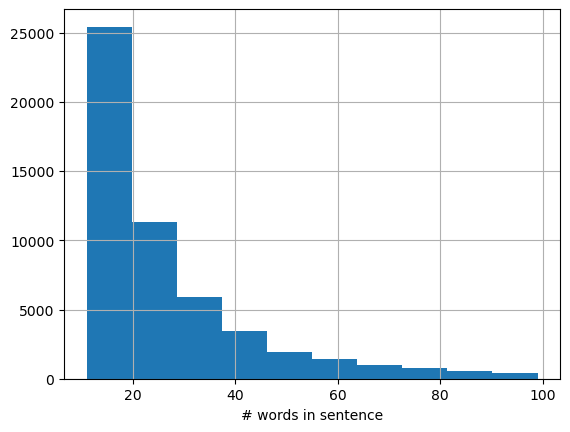

In [8]:
# sentences that are too short (less than 10 words) or too long (more than 100 words) are filtered out
train_df = train_df[(train_df['length']>10) & (train_df['length']<100)]
test_df = test_df[(test_df['length']>10) & (test_df['length']<100)]
train_df['length'].hist()
plt.xlabel("# words in sentence")
plt.show()

In [9]:
# dataset is filtered to keep only the 'tokenized_sen' and 'label' columns.
train_df = train_df[['tokenized_sen', 'label']]
test_df = test_df[['tokenized_sen', 'label']]
train_df.head()

,tokenized_sen,label
891545,"[1383, 1246, 1266, 374, 13, 439, 360, 2, 1, 35...",0
27711,"[2972, 4, 1984, 208, 72, 9, 9348, 36, 86, 72, ...",0
143283,"[25, 144, 1418, 149, 88, 1445, 75, 10, 7, 52, ...",0
486896,"[6, 42, 70, 56, 1743, 3861, 8, 23, 14, 128, 86...",1
4144,"[6, 104, 87, 3, 1726, 184, 17, 4, 6340, 583, 6...",0


In [10]:
len(train_df), len(test_df)

(52275, 12915)

In [11]:
# Define x_train and y_train

x_train = train_df['tokenized_sen']
y_train = train_df['label']

x_test = test_df['tokenized_sen']
y_test = test_df['label']

## Step 3: Padding Sequences
Padding Sequences ensures input data is uniformly formatted for the model.
Plotting Curves provides a visual diagnostic to evaluate the training process and detect overfitting/underfitting.

In [12]:
# max word length for each review will be 500
max_words = 500

# the pad_sequences function is used to ensure ALL the text sequences in training and test are the same length
X_train = sequence.pad_sequences(x_train, maxlen=max_words,padding='pre')
X_test = sequence.pad_sequences(x_test, maxlen=max_words,padding='pre')

# utility function for plotting
def plot_model_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=80)

    ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
    ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
    ax[0].grid(alpha=0.3)
    ax[0].title.set_text('Training Vs Validation Accuracy')
    plt.setp(ax[0], xlabel='Epochs')
    plt.setp(ax[0], ylabel='Accuracy')
    
    ax[0].legend(loc=0)

    ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
    ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
    ax[1].grid(alpha=0.3)
    ax[1].title.set_text('Training Vs Validation Loss')
    plt.setp(ax[1], xlabel='Epochs')
    plt.setp(ax[1], ylabel='Loss')
    
    ax[1].legend(loc=0)

    plt.show()

## Step 4: Training the Model with LSTM
We'll train the model for 10 epochs and monitor training and validation accuracy/loss. I used less and more epochs before but this seemed like the most optimal fit.

In [13]:
emb_size = 30 # this sets the size of the vector that will represent each word in the input text
hidden_size = 3 # this determines the size of the output of the LSTM layer

In [14]:
tf.keras.backend.clear_session() # to clear any previous models or operations that are held in memory

model  = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.num_words+1, emb_size, mask_zero=True),
    tf.keras.layers.LSTM(hidden_size),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# 10 epochs with a batch size of 512
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=512)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.5529 - loss: 0.6882 - val_accuracy: 0.5612 - val_loss: 0.6830
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.5649 - loss: 0.6749 - val_accuracy: 0.5707 - val_loss: 0.6801
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.6284 - loss: 0.6435 - val_accuracy: 0.5608 - val_loss: 0.6913
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.6681 - loss: 0.6083 - val_accuracy: 0.5529 - val_loss: 0.7064
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.6936 - loss: 0.5806 - val_accuracy: 0.5508 - val_loss: 0.7321
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.7186 - loss: 0.5517 - val_accuracy: 0.5446 - val_loss: 0.7531
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.7372 - loss: 0.5302 - val_accuracy: 0.5415 - val_loss: 0.7808
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.7483 - loss: 0

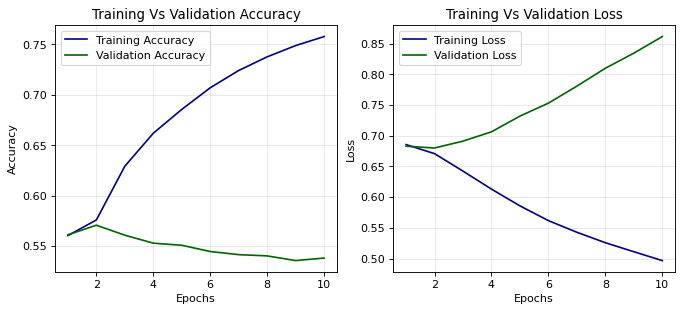

In [16]:
# plotting training curves
plot_model_curves(history)

**What inferences we can make from training accuracy and loss:**

The training accuracy improves steadily across all 10 epochs, starting at 55.29% in epoch 1 and reaching 77.08% by epoch 10. This shows that the model is effectively learning from the training data and making progress in its predictions. Similarly, the training loss decreases from 0.6882 in epoch 1 to 0.4831 by epoch 10, indicating that the model is reducing errors and becoming more precise as it trains. Although the improvement is gradual, it's a positive trend, especially with limited data.

**And for validation accuracy and loss, we can say:**

The validation accuracy starts at 56.12% in epoch 1 and experiences a slight fluctuation throughout the 10 epochs, dropping to 53.81% by epoch 10. This lack of significant improvement and the overall decline in validation accuracy suggest that the model is struggling to generalize to unseen data. The validation loss starts at 0.6830 in epoch 1, increases slightly to 0.6913 by epoch 3, and continues to rise through epoch 10, ending at 0.8615.

These patterns indicate that the model is likely overfitting to the training data. While the model shows improvement on the training set, it fails to achieve similar progress on the validation set. The increasing validation loss and declining validation accuracy further confirm that the model is not generalizing well to unseen data. This suggests that techniques like regularization could be considered to help the model better generalize and improve its performance on the validation set.

## Step 5: Adressing the Overfitting Issue

**What are some signs of overfitting?**

The increasing gap between training accuracy and validation accuracy, along with the fluctuating validation accuracy, is a clear sign of overfitting in our model. While the training accuracy continues to improve over epochs, the validation accuracy either remains constant or decreases. Additionally, the increasing validation loss, despite the decreasing training loss, further confirms that the model is not generalizing well to unseen data. This suggests that the model is memorizing the training set rather than learning to generalize to the validation set.


**What can be done to lessen / overcome overfitting:**

**1- Regularization:** By adding methods like dropout, L1/L2 weight regularization, or data augmentation we can try to lessen the effects of overfitting.  
**2- Improving the model:** If the model appears too simple, we can increase its size or the number of parameters it has.  
**3- More data:** More data can be used to have a better shot at performance. 
**4- Training more:** The model can have a longer, more expensive training session to see if it helps.

By addressing some of these issues, the model can achieve better generalization and improve its overall performance.

## Step 6: Using the Model

In [22]:
# Predict on the test set
pred = model.predict(X_test)
pred = pred.argmax(axis=1)

408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_seq_len = 100

# example input text to test out
text = ["Wow, thank you so much for explaining that. You should help me with math some time, seems like I can't put 2 and 2 together!"]

# Tokenize and convert to sequences
seq = tokenizer.texts_to_sequences(text)

# Pad the sequences to ensure uniform input size
padded_seq = pad_sequences(seq, maxlen=max_seq_len, padding='post')

# Predict the output
pred = model.predict(padded_seq)

# Determine the predicted class
pred_class = pred.argmax(axis=-1)

# Print the result
if pred_class[0] == 0:
    print(text[0] + " --> No sarcasm. " + str(np.round(pred[0].max() * 100, 2)) + "%")
else:
    print(text[0] + " --> Sarcasm. " + str(np.round(pred[0].max() * 100, 2)) + "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Wow, thank you so much for explaining that. You should help me with math some time, seems like I can't put 2 and 2 together! --> Sarcasm. 59.22%


The model correctly identified sarcasm in the test sentence, "Wow, thank you so much for explaining that. You should help me with math some time, seems like I can't put 2 and 2 together!" with a confidence of 59.22%. This suggests that the model is able to detect sarcasm in my test text, although the confidence score indicates that there is still room for improvement in its accuracy and generalization.

## Summary

In this approach, we used a simple model to address the task, which worked well for training on a smaller dataset. The model's architecture included an embedding layer to convert text into dense vectors, an LSTM layer for capturing sequential patterns, and a dense layer for classification.

**Key Observations:**

The model showed good improvement in training accuracy over the epochs, suggesting that it was learning from the training data.
However, there were signs of overfitting, evident from the increasing gap between the training and validation accuracy, as well as the rise in validation loss despite decreasing training loss. This indicates that the model performed well on the training set but struggled to generalize to the validation set.

**For the future:** I see a lot of room for potential improvements, like trying transfer learning with pre-trained models. I have achieved better results when I tried a pre-trained model on another project, so I will try to see how that goes for this model as well. It could be fun to experiment with advanced architectures like ResNet, or fine-tuning hyperparameters further. 

This project provided valuable hands-on experience in designing, training, and evaluating NLP models. Through experimentation and analysis, I gained a better understanding of LSTMs and how to apply them for this purpose.

**Thank you for reading!**